# Notebook 2: DCGAN for 64x64 HumanFaces

This tutorial demonstrates how to generate pictures of human faces using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). It is based on the original Tensorflow tutorial and adaptions made in Notebook 1 (Text-to-Image DCGAN for 28x28 MNIST). Compared to Notebook 1 we will skip the additional text input for now to validate that the model is able to generate a real human face with the given data. The fake image created by the generator will have a shape of 64x64x1.

## Setup
Import required dependencies/packages and define input/output locations.

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.9.1'

Check whether your GPU is correctly set up.
I'm using a NVIDIA RTX 2080 with CUDA 11.2 and cuDNN 8.4.1.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import time
import pickle
from tqdm import tqdm
from PIL import Image

In [5]:
data_dir = "data/humanfaces"
dataset_dir = f"{data_dir}/dataset"
output_dir = "output/2-dcgan-humanfaces-64x64"
checkpoint_dir = f"{output_dir}/training_checkpoints"

## The dataset

The dataset is published under the [CC0 1.0 Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/) license on [Kaggle](https://www.kaggle.com/datasets/ashwingupta3012/human-faces).


In [6]:
if not os.path.exists(dataset_dir) or len(os.listdir(dataset_dir)) == 0:
    print("Please download the dataset manually and place the images in ./data/humanfaces/dataset")
    print("https://www.kaggle.com/datasets/ashwingupta3012/human-faces")
    raise FileNotFoundError("Data not found.")

As the publisher stated the dataset is "a thorough mix of all common creeds, races, age groups and profiles in an attempt to create an unbiased dataset". Not only the people on the images are different, even the shapes vary. The goal of this notebook is to create a random human face. In order to decrease the complexity of the task, we manually selected a subset of images of men of all creeds, races and age groups that are not cut off and facing towards the camera. The filenames of the selected image are stored in `./data/humanfaces/selected_men.pkl`. The list includes a total of 575 faces.

In [7]:
with open(f"{data_dir}/selected_men.pkl", "rb") as handle:
    filenames = pickle.load(handle)

Load and prepare the dataset

In [8]:
BUFFER_SIZE = len(filenames) # 575
BATCH_SIZE = 8
pixel = 64

In [9]:
images = []

for f in tqdm(filenames):
    im = Image.open(f"{dataset_dir}/{f}")
    im = im.resize((pixel, pixel))
    im = im.convert('L')
    im = imageio.core.util.Array(np.asarray(im))
    im = im.reshape(pixel, pixel, 1).astype('float32')
    im = (im - 127.5) / 127.5  # Normalize the images to [-1, 1]

    images.append(im)

100%|██████████| 575/575 [00:13<00:00, 42.42it/s]


Visualize an example image.

1 (995).jpg


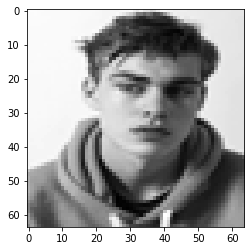

In [10]:
print(f)
plt.imshow(im, cmap='gray')

Convert the lists to ndarrays.

In [11]:
def convert_to_nparray(name, arr):
    np_array = np.asarray(arr)
    print(f"### {name} ###")
    print(type(np_array))
    print(np_array.shape)
    return np_array

In [12]:
awesome_images = convert_to_nparray("images", images)

### images ###
<class 'numpy.ndarray'>
(575, 64, 64, 1)


In [13]:
awesome_train_dataset = tf.data.Dataset.from_tensor_slices({"image": awesome_images})\
    .shuffle(BUFFER_SIZE)\
    .batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Create the models

Both generator and discriminator are following the layer design described in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) with one difference in the output shape. The reference shows a shape of 64x64x3 while we'll work with a shape of 64x64x1.

![](docs/DCGAN_Generator.png)

In [14]:
noise_dim = 100

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes the seed, then upsample several times until you reach the desired image size of 64x64x1. Notice the `tf.keras.layers.ReLU` activation for each layer, except the output layer which uses tanh. This is a difference to the previous notebooks in which the `tf.keras.layers.LeakyReLU` was used.

In [15]:
def make_generator_model():
    image_input = layers.Input(shape=(100,), name='noise')

    x = layers.Dense(4 * 4 * 1024, use_bias=False)(image_input)
    x = layers.Reshape((4, 4, 1024))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    inputs = [image_input]
    return Model(inputs=inputs, outputs=x, name="generator")

Build the generator model and summarize the structure.

In [16]:
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 1024)       4096      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107200  
 nspose)                                                 

Use the (as yet untrained) generator to create an image.

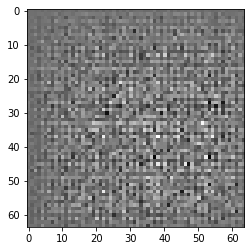

In [17]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator({"noise": noise}, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [18]:
def make_discriminator_model():
    image_input = layers.Input(shape=(pixel, pixel, 1), name='image')

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(1)(x)

    inputs = [image_input]
    return Model(inputs=inputs, outputs=x, name="discriminator")

Build the generator model and summarize the structure.

In [19]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                     

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
decision = discriminator({"image": generated_image})
print(decision)

tf.Tensor([[-1.682794e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [25]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop
The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator({"noise": noise}, training=True)

      real_output = discriminator({"image": batch["image"]}, training=True)
      fake_output = discriminator({"image": generated_images}, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
  for epoch in range(1, epochs+1):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    show = True if (epoch % VISUALIZE_EVERY_X_EPOCHS) == 0 else False
    generate_and_save_images(generator, test_noise, "{}/image_at_epoch_{:04d}.png".format(output_dir, epoch), show=show)

    if (epoch % CHECKPOINT_EVERY_X_EPOCHS) == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

**Generate and save images**


In [28]:
num_examples_to_generate = 16
test_noise = tf.random.normal([num_examples_to_generate, noise_dim])

In [29]:
def generate_and_save_images(model, noise, output_path, show, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model({"noise": noise}, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save:
    plt.savefig(output_path)
  if show:
    plt.show()

  plt.close(fig)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

In [30]:
os.makedirs(output_dir, exist_ok=True)

Time for epoch 1 is 5.447258472442627 sec
Time for epoch 2 is 2.7891087532043457 sec
Time for epoch 3 is 2.792107343673706 sec
Time for epoch 4 is 2.7601191997528076 sec


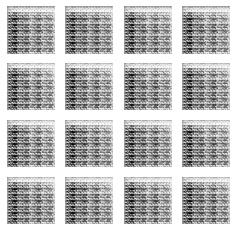

Time for epoch 5 is 3.097011089324951 sec
Time for epoch 6 is 2.778110980987549 sec
Time for epoch 7 is 2.8240981101989746 sec
Time for epoch 8 is 2.707134962081909 sec
Time for epoch 9 is 3.034029245376587 sec


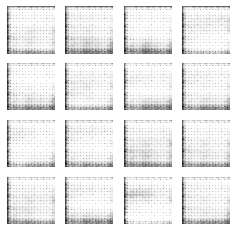

Time for epoch 10 is 2.887077569961548 sec
Time for epoch 11 is 2.717132568359375 sec
Time for epoch 12 is 2.97804856300354 sec
Time for epoch 13 is 2.713132381439209 sec
Time for epoch 14 is 2.7141332626342773 sec


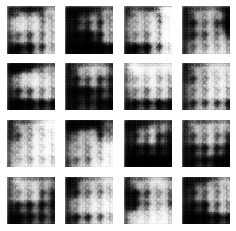

Time for epoch 15 is 2.971050500869751 sec
Time for epoch 16 is 3.2999467849731445 sec
Time for epoch 17 is 2.8860762119293213 sec
Time for epoch 18 is 2.8510923385620117 sec
Time for epoch 19 is 3.030029058456421 sec


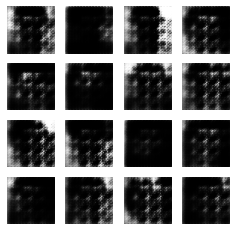

Time for epoch 20 is 4.090692520141602 sec
Time for epoch 21 is 2.7121341228485107 sec
Time for epoch 22 is 3.0480265617370605 sec
Time for epoch 23 is 2.8071069717407227 sec
Time for epoch 24 is 2.7901031970977783 sec


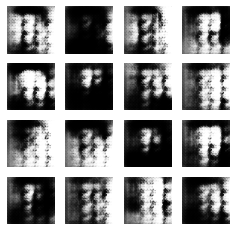

Time for epoch 25 is 2.9680519104003906 sec
Time for epoch 26 is 3.1290009021759033 sec
Time for epoch 27 is 3.3679237365722656 sec
Time for epoch 28 is 4.3191633224487305 sec
Time for epoch 29 is 3.0700132846832275 sec


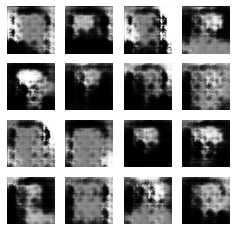

Time for epoch 30 is 2.958054542541504 sec
Time for epoch 31 is 2.8081037998199463 sec
Time for epoch 32 is 3.5768563747406006 sec
Time for epoch 33 is 3.702816963195801 sec
Time for epoch 34 is 4.12468147277832 sec


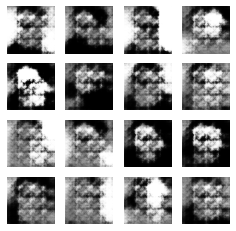

Time for epoch 35 is 3.032031536102295 sec
Time for epoch 36 is 3.0880126953125 sec
Time for epoch 37 is 2.7911083698272705 sec
Time for epoch 38 is 2.8061065673828125 sec
Time for epoch 39 is 3.879757881164551 sec


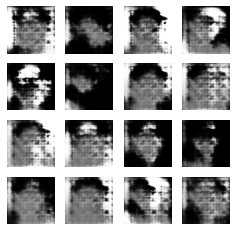

Time for epoch 40 is 4.246642112731934 sec
Time for epoch 41 is 3.2239723205566406 sec
Time for epoch 42 is 3.2369635105133057 sec
Time for epoch 43 is 2.8101019859313965 sec
Time for epoch 44 is 2.856088638305664 sec


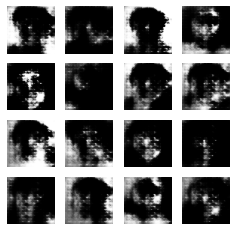

Time for epoch 45 is 2.9910433292388916 sec
Time for epoch 46 is 3.2899484634399414 sec
Time for epoch 47 is 2.9670517444610596 sec
Time for epoch 48 is 2.860085964202881 sec
Time for epoch 49 is 2.9590556621551514 sec


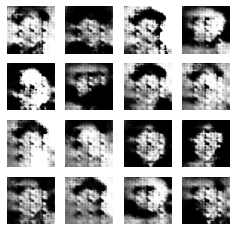

Time for epoch 50 is 2.9670512676239014 sec
Time for epoch 51 is 2.812100648880005 sec
Time for epoch 52 is 3.04202938079834 sec
Time for epoch 53 is 2.724128484725952 sec
Time for epoch 54 is 2.7301268577575684 sec


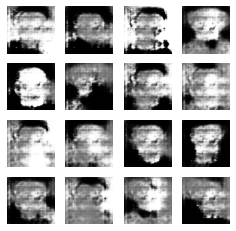

Time for epoch 55 is 2.9020750522613525 sec
Time for epoch 56 is 2.9890427589416504 sec
Time for epoch 57 is 2.8520889282226562 sec
Time for epoch 58 is 2.7061359882354736 sec
Time for epoch 59 is 2.868082284927368 sec


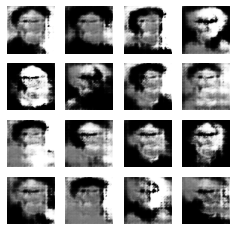

Time for epoch 60 is 4.051705837249756 sec
Time for epoch 61 is 2.74212384223938 sec
Time for epoch 62 is 3.024033546447754 sec
Time for epoch 63 is 2.728127956390381 sec
Time for epoch 64 is 2.7191321849823 sec


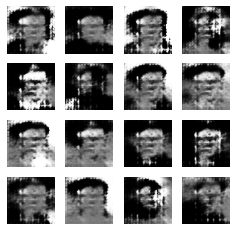

Time for epoch 65 is 2.89007568359375 sec
Time for epoch 66 is 2.9860458374023438 sec
Time for epoch 67 is 2.7351269721984863 sec
Time for epoch 68 is 2.761117696762085 sec
Time for epoch 69 is 2.8740808963775635 sec


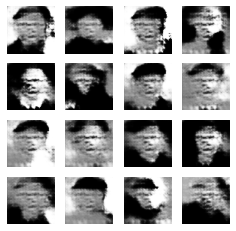

Time for epoch 70 is 2.8860785961151123 sec
Time for epoch 71 is 2.7341272830963135 sec
Time for epoch 72 is 3.0270347595214844 sec
Time for epoch 73 is 2.7281253337860107 sec
Time for epoch 74 is 2.7511203289031982 sec


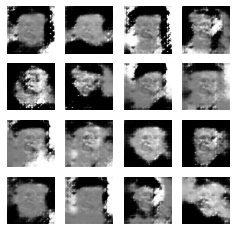

Time for epoch 75 is 2.893075942993164 sec
Time for epoch 76 is 2.960054636001587 sec
Time for epoch 77 is 2.7391247749328613 sec
Time for epoch 78 is 2.742126941680908 sec
Time for epoch 79 is 2.925062894821167 sec


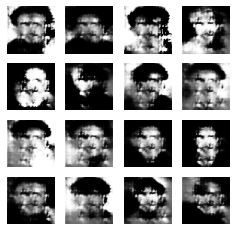

Time for epoch 80 is 4.04770565032959 sec
Time for epoch 81 is 2.7531206607818604 sec
Time for epoch 82 is 3.031031370162964 sec
Time for epoch 83 is 2.715132713317871 sec
Time for epoch 84 is 2.709134578704834 sec


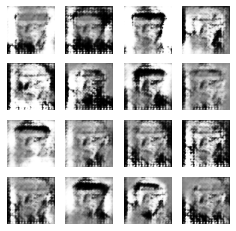

Time for epoch 85 is 2.9270639419555664 sec
Time for epoch 86 is 3.00603985786438 sec
Time for epoch 87 is 2.781111478805542 sec
Time for epoch 88 is 2.8250977993011475 sec
Time for epoch 89 is 2.8990726470947266 sec


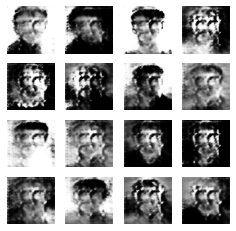

Time for epoch 90 is 2.880080461502075 sec
Time for epoch 91 is 2.7171308994293213 sec
Time for epoch 92 is 3.0360307693481445 sec
Time for epoch 93 is 2.7571187019348145 sec
Time for epoch 94 is 2.7981057167053223 sec


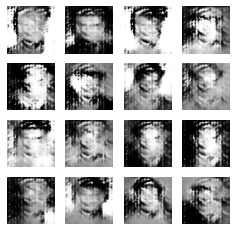

Time for epoch 95 is 2.9840471744537354 sec
Time for epoch 96 is 3.0740177631378174 sec
Time for epoch 97 is 2.7161314487457275 sec
Time for epoch 98 is 2.7251293659210205 sec
Time for epoch 99 is 2.8760814666748047 sec


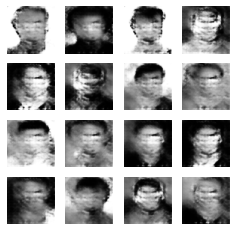

KeyboardInterrupt: 

In [31]:
VISUALIZE_EVERY_X_EPOCHS = 5
CHECKPOINT_EVERY_X_EPOCHS = 20
EPOCHS = 200
train(awesome_train_dataset, EPOCHS)

*Note: The model training was manually stopped.*

Let's not beat around the bush, the results are bad.
With some imagination the outlines of a face can be assumed, but it's not the quality that we would require to be able to describe the hair, eyes, nose, mouth or other facial characteristics.

Restore the latest checkpoint.

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

Use `imageio` to create an animated gif using the images saved during training.

In [33]:
anim_file = f"{output_dir}/dcgan.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(f"{output_dir}/image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\Tom\AppData\Local\Temp\ipykernel_15740\254506623.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Tom\AppData\Local\Temp\ipykernel_15740\254506623.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



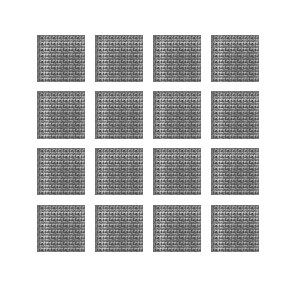

In [34]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Conclusion

The results are bad, but this is what we expected. We are facing a much more complex task compared to generating handwritten digits, but at the same time we are using a dataset of in total 575 images compared to the previously 70000 handwritten digits. Most likely a dataset of several tens of thousands is required to achieve a proper generated fake image of a human face.